In [1]:
from pathlib import Path
from pylook.units import units
import pylook.calc as lc
from pylook.io import read_binary
import numpy as np
import pandas as pd
import h5py as h5
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
def read_hdf(fileName):
    data = pd.DataFrame()
    for chanName in h5.File(fileName, "r")['mechData'].keys():
        data[chanName] = h5.File(fileName, "r")['mechData'][chanName]
    return data

In [3]:
def pl(y, y2=None, idx1=0, idx2=-1, ylog=False, y2log=False):
    %matplotlib widget
    fig, axs = plt.subplots(1, 1, figsize=(12, 5), sharex=True)
    axs.plot(data[y][idx1:idx2], color='blue')
    if ylog == True:
        axs.set_yscale('log')
    plt.show()

    if y2 != None:
        %matplotlib widget
        fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
        axs[0].plot(data[y][idx1:idx2], color='blue')
        axs[1].plot(data[y2][idx1:idx2], color='red')
        if ylog == True:
            axs[0].set_yscale('log')
        if y2log == True:
            axs[1].set_yscale('log')
        
        plt.show()

In [4]:
data = read_hdf("p5708_py.h5")

In [5]:
data['Time'] = np.cumsum(data['Time']/1e4)
data['time'] = data.pop('Time')

data['norm disp'] = data.pop('Hor DCDT')
data['norm stress'] = data.pop('Hor LOAD')
data['pc disp'] = data.pop('Pc Disp')
data['pc press'] = data.pop('Pc LOAD')
data['ppa disp'] = data.pop('Ppa Disp')
data['ppa press'] = data.pop('Ppa LOAD')
data['ppb press'] = data.pop('Ppb LOAD')
data['ppb disp'] = data.pop('Ppb Disp')
data['int disp'] = data.pop('Int DCDT')

In [6]:
# CALIBRATIONS FOR DISPLACEMENTS AND STRESSES
#---------------------------------------------------------------------------------------

# HORIZONTAL DISPLACEMENT
# high gain, short rod: 0.657956387503886 mm/V
h_disp_calib = (20/2**24)  * 0.657956387503886 * 1000 #um/mm 
data['norm disp'] = data['norm disp'] * h_disp_calib

# HORIZONTAL INTERNAL DISPLACEMENT
# high gain: 0.415958632711548 mm/V
Hint_disp_calib = (20/2**24)  * 0.415958632711548 * 1000 #um/mm 
data['int disp'] = data['int disp'] * Hint_disp_calib

# HORIZONTAL LOAD
# high gain: 129.9546436 mV/kN
# 1 surface
# area: 0.0022231311 m^2
h_load_calib = 1 * 0.0022292545 * 129.9546436 * (2**24/20)
data['norm stress'] = data['norm stress'] * 1/h_load_calib

#---------------------------------------------------------------------------------------

# Pc INTENSIFIER DISPLACEMNT
# high gain: 29.49852507 mm/V 
# ((20/2**24) * units('V / bit')) * (29.499 * units('mm / V') * 1000 * units('micron / mm'))
pc_disp_calib = (20/2**24) * 29.49852507 * 1000 #um/mm
data['pc disp'] = data['pc disp'] * pc_disp_calib

# Pc PRESSURE
# high gain: 0.14556041 V/MPa
pc_pres_calib = (20/2**24)  * 1/0.14556041
data['pc press'] = data['pc press'] * pc_pres_calib

#---------------------------------------------------------------------------------------
                                                     
# PpA INTENSIFIER DISPLACEMNT
# high gain: 26.73796791 mm/V 
ppa_disp_calib = (20/2**24) * 26.73796791 * 1000 #um/mm
data['ppa disp'] = data['ppa disp'] * ppa_disp_calib

# PpA PRESSURE
# high gain: 1.517680983 V/MPa
ppa_pres_calib = (20/2**24) * 1/1.517680983
data['ppa press'] = data['ppa press'] * ppa_pres_calib
                               
#---------------------------------------------------------------------------------------
                                                      
# PpB INTENSIFIER DISPLACEMNT
# high gain: 26.88172043 mm/V 
ppb_disp_calib = (20/2**24) * 26.88172043 * 1000 #um/mm
data['ppb disp'] = data['ppb disp'] * ppb_disp_calib

# PpB PRESSURE
# high gain: 1.48 V/MPa
ppb_pres_calib = (20/2**24) * 1/1.483019428
data['ppb press'] = data['ppb press'] * ppb_pres_calib
                                                      
#---------------------------------------------------------------------------------------                                                      

In [7]:
# pl('ppa press', 'ppb press', 0, -1)

In [8]:
# OFFSETS AND ZERO POINTS

# HOR DISP
data['norm disp'] = lc.zero(data['norm disp'], 723, mode='before')

# INT HOR DISP
data['int disp'] = lc.zero(data['int disp'], 723, mode='before')

# HOR LOAD
data['norm stress'] = lc.zero(data['norm stress'], 724, mode='before')

# PC DISP
data['pc disp'] = lc.zero(data['pc disp'], 2615, mode='before')

# PC LOAD
data['pc press'] = lc.zero(data['pc press'], 2615, mode='before')

# Ppa LOAD
data['ppa press'] = lc.zero(data['ppa press'], 78273, mode='before')
data['ppa disp'] = lc.zero(data['ppa disp'], 78279, mode='before')

# Ppb LOAD
data['ppb press'] = lc.zero(data['ppb press'], 77406, mode='before') +1
data['ppb disp'] = lc.zero(data['ppb disp'], 77187, mode='before')




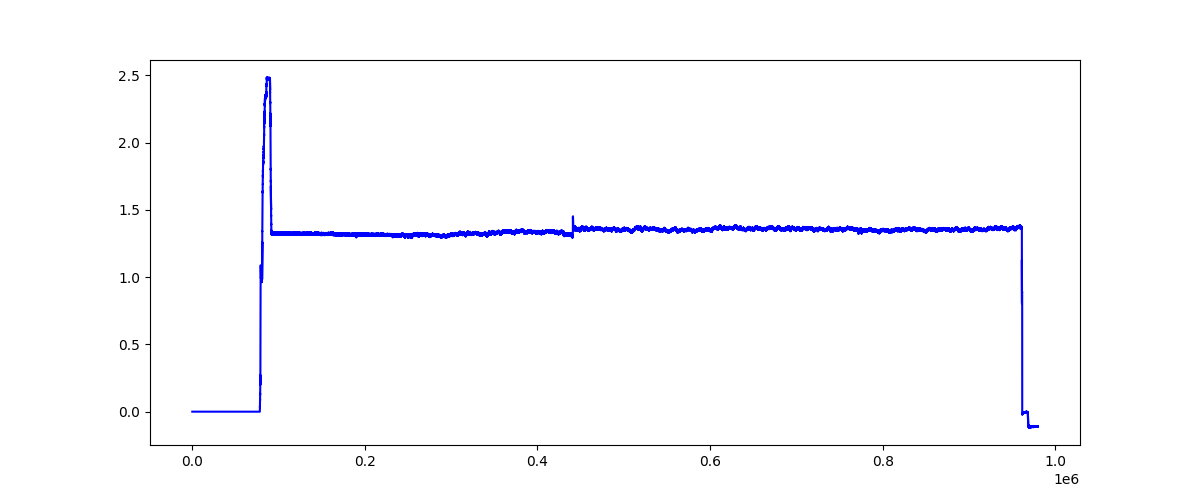

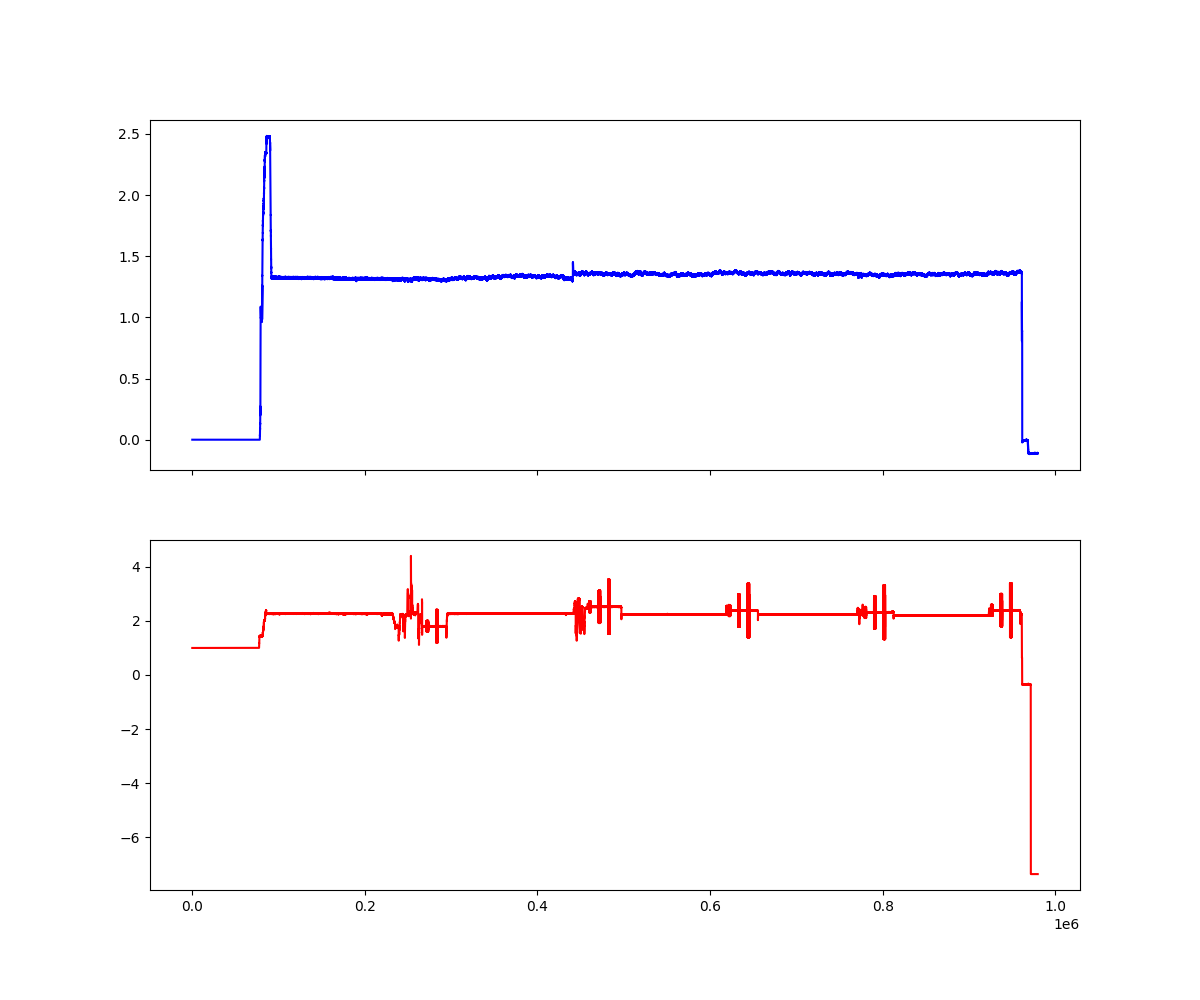

In [9]:
pl('ppa press', 'ppb press', 0, -1)

In [10]:
##################################################################################
# cjm & cew; updated for True Triax config. 20181031                             #
#                                                                                #
#                                                                                #
#   In the vessel for SDS with notched L-shaped samples:                         #
#               Shear Stress is given by: tau = (FVp - Pc*Ap)/A                  #
#               Normal stress is given by: sigma_n = (FHp + Pc(A-Ap))/A          #
#                    or, sigma_n = FHp/A + Pc(A-Ap)/A                            #
#  where:                                                                        #
#  FVp is vertical force applied by the piston                                   #
#  FHp is horizontal force applied by the piston                                 #
#  A is the smaller area of the L-shaped samples                                 #
#   note that the frictional contact area will be given by the block thickness.  #
#  The eventual fracture plane will be given by the distance between the notches #
#  Ap is the area of the piston                                                  #
#  Pc is the confining pressure                                                  #
#                                                                                #
##################################################################################


# Account for Pc Force pushing on pistons
# Horizontal Area = 0.0022292545 m^2
A = 0.0022231311
#adjust normal stress for Pc.
#Area of piston, Ap = 44mm (dia) =  0.00152053084 m^2
Ap = 0.044 * np.pi
Pc_area = 100 - (Ap-A)/A
# ~ 32% of Pc is added to the applied horizontal stress to get the effective stress

# Calculate Effective Stresses
data['effNS'] = data['norm stress'] + (data['pc press'] * Pc_area/100) - (data['ppa press'] + data['ppb press'])/2

In [11]:
from perm_funcs import movingslope, movingmean

###############################################################################
# VOLUMETRIC FLOW                                                             #
# first, calculate displacement rate of the pistons with running avg. slope   #
# then, multiply by inner diameter of intensifiers for volumetric rate        #
###############################################################################

# sampfreq = 1000;

# idxfs100only = np.where(np.logical_and(sampfreq > 90, sampfreq < 110))

# data['PpDiff'][idxfs100only];

###############################################################################

# calculate Pressure differential & convert from [MPa] --> [Pa]
data['PpDiff'] = (data['ppb press'] - data['ppa press']) * 1e6 #Pa

data['mmPpDiff'] = movingmean(data['PpDiff'],101);

# INTENSIFIER DISPLACEMENT RATES
data['AvPparate'] = movingslope(data['ppa disp'], 101)
data['AvPpbrate'] = movingslope(data['ppb disp'], 101)

# INTENSIFIER VOLUME
piston_dia = 0.0254 #meter
Vol_int = np.pi*(piston_dia/2)**2 #m^2

# FLOW RATES
data['Qa'] = data['AvPparate']/1e6 * Vol_int #m^3/s
data['Qb'] = -1*data['AvPpbrate']/1e6 * Vol_int #m^3/s

#flow in this exp is from to B to A
#check to make sure we have steady-state flow -- percent difference 
data['QpctDiff'] = (data['Qb'] - data['Qa']) / data['Qb'] * 100 #percent

#calculate an average flow rate from upsteam and downstream
data['Qavg'] = (data['Qa'] + data['Qb'])/2 #m^3/s

# Fracture plane length x thickness 45 x 23.43 = 0.00105435 m^2
A_flow = 0.045 * 0.02343 #m^2

# flow length is 0.04976 m
L_flow = 0.04976 #meter

#viscosity of water at 25 deg. C = 1e-3 Pa.s
nu = 1e-3 #Pa.s

# permeability calculation [m^2]
data['perm'] = (data['Qavg'] * nu * L_flow)/(data['mmPpDiff'] * A_flow) #[m^2]

In [12]:
# pl('effNS', 'PpDiff', y2log=False, idx1=80000, idx2=960000)

In [13]:
max_flow_diff_percent = 75
# min_flow = 1; # in m^3/s. Minimum flow

flow_diff_idxs = data['QpctDiff'].abs().to_numpy() > max_flow_diff_percent
# min_flow_idxs = np.logical_or(data['Qa'].to_numpy() <= min_flow, data['Qb'].to_numpy() >= min_flow)

data['perm'].to_numpy()[flow_diff_idxs] = np.nan
# data['perm'].to_numpy()[min_flow_idxs] = np.nan

In [14]:
# %matplotlib widget
# fig, axs = plt.subplots(1, 1, figsize=(12, 5), sharex=True)
# axs.plot(data['effNS'], zorder=0)
# axs.scatter(NS_begin.flatten(), data['effNS'][NS_begin.flatten()], c='k', zorder=1)
# axs.scatter(NS_end.flatten(), data['effNS'][NS_end.flatten()], c='r', zorder=1)
# axs.scatter(PP_begin.flatten(), data['effNS'][PP_begin.flatten()], c='k', zorder=1)
# axs.scatter(PP_end.flatten(), data['effNS'][PP_end.flatten()], c='r', zorder=1)
# plt.show()

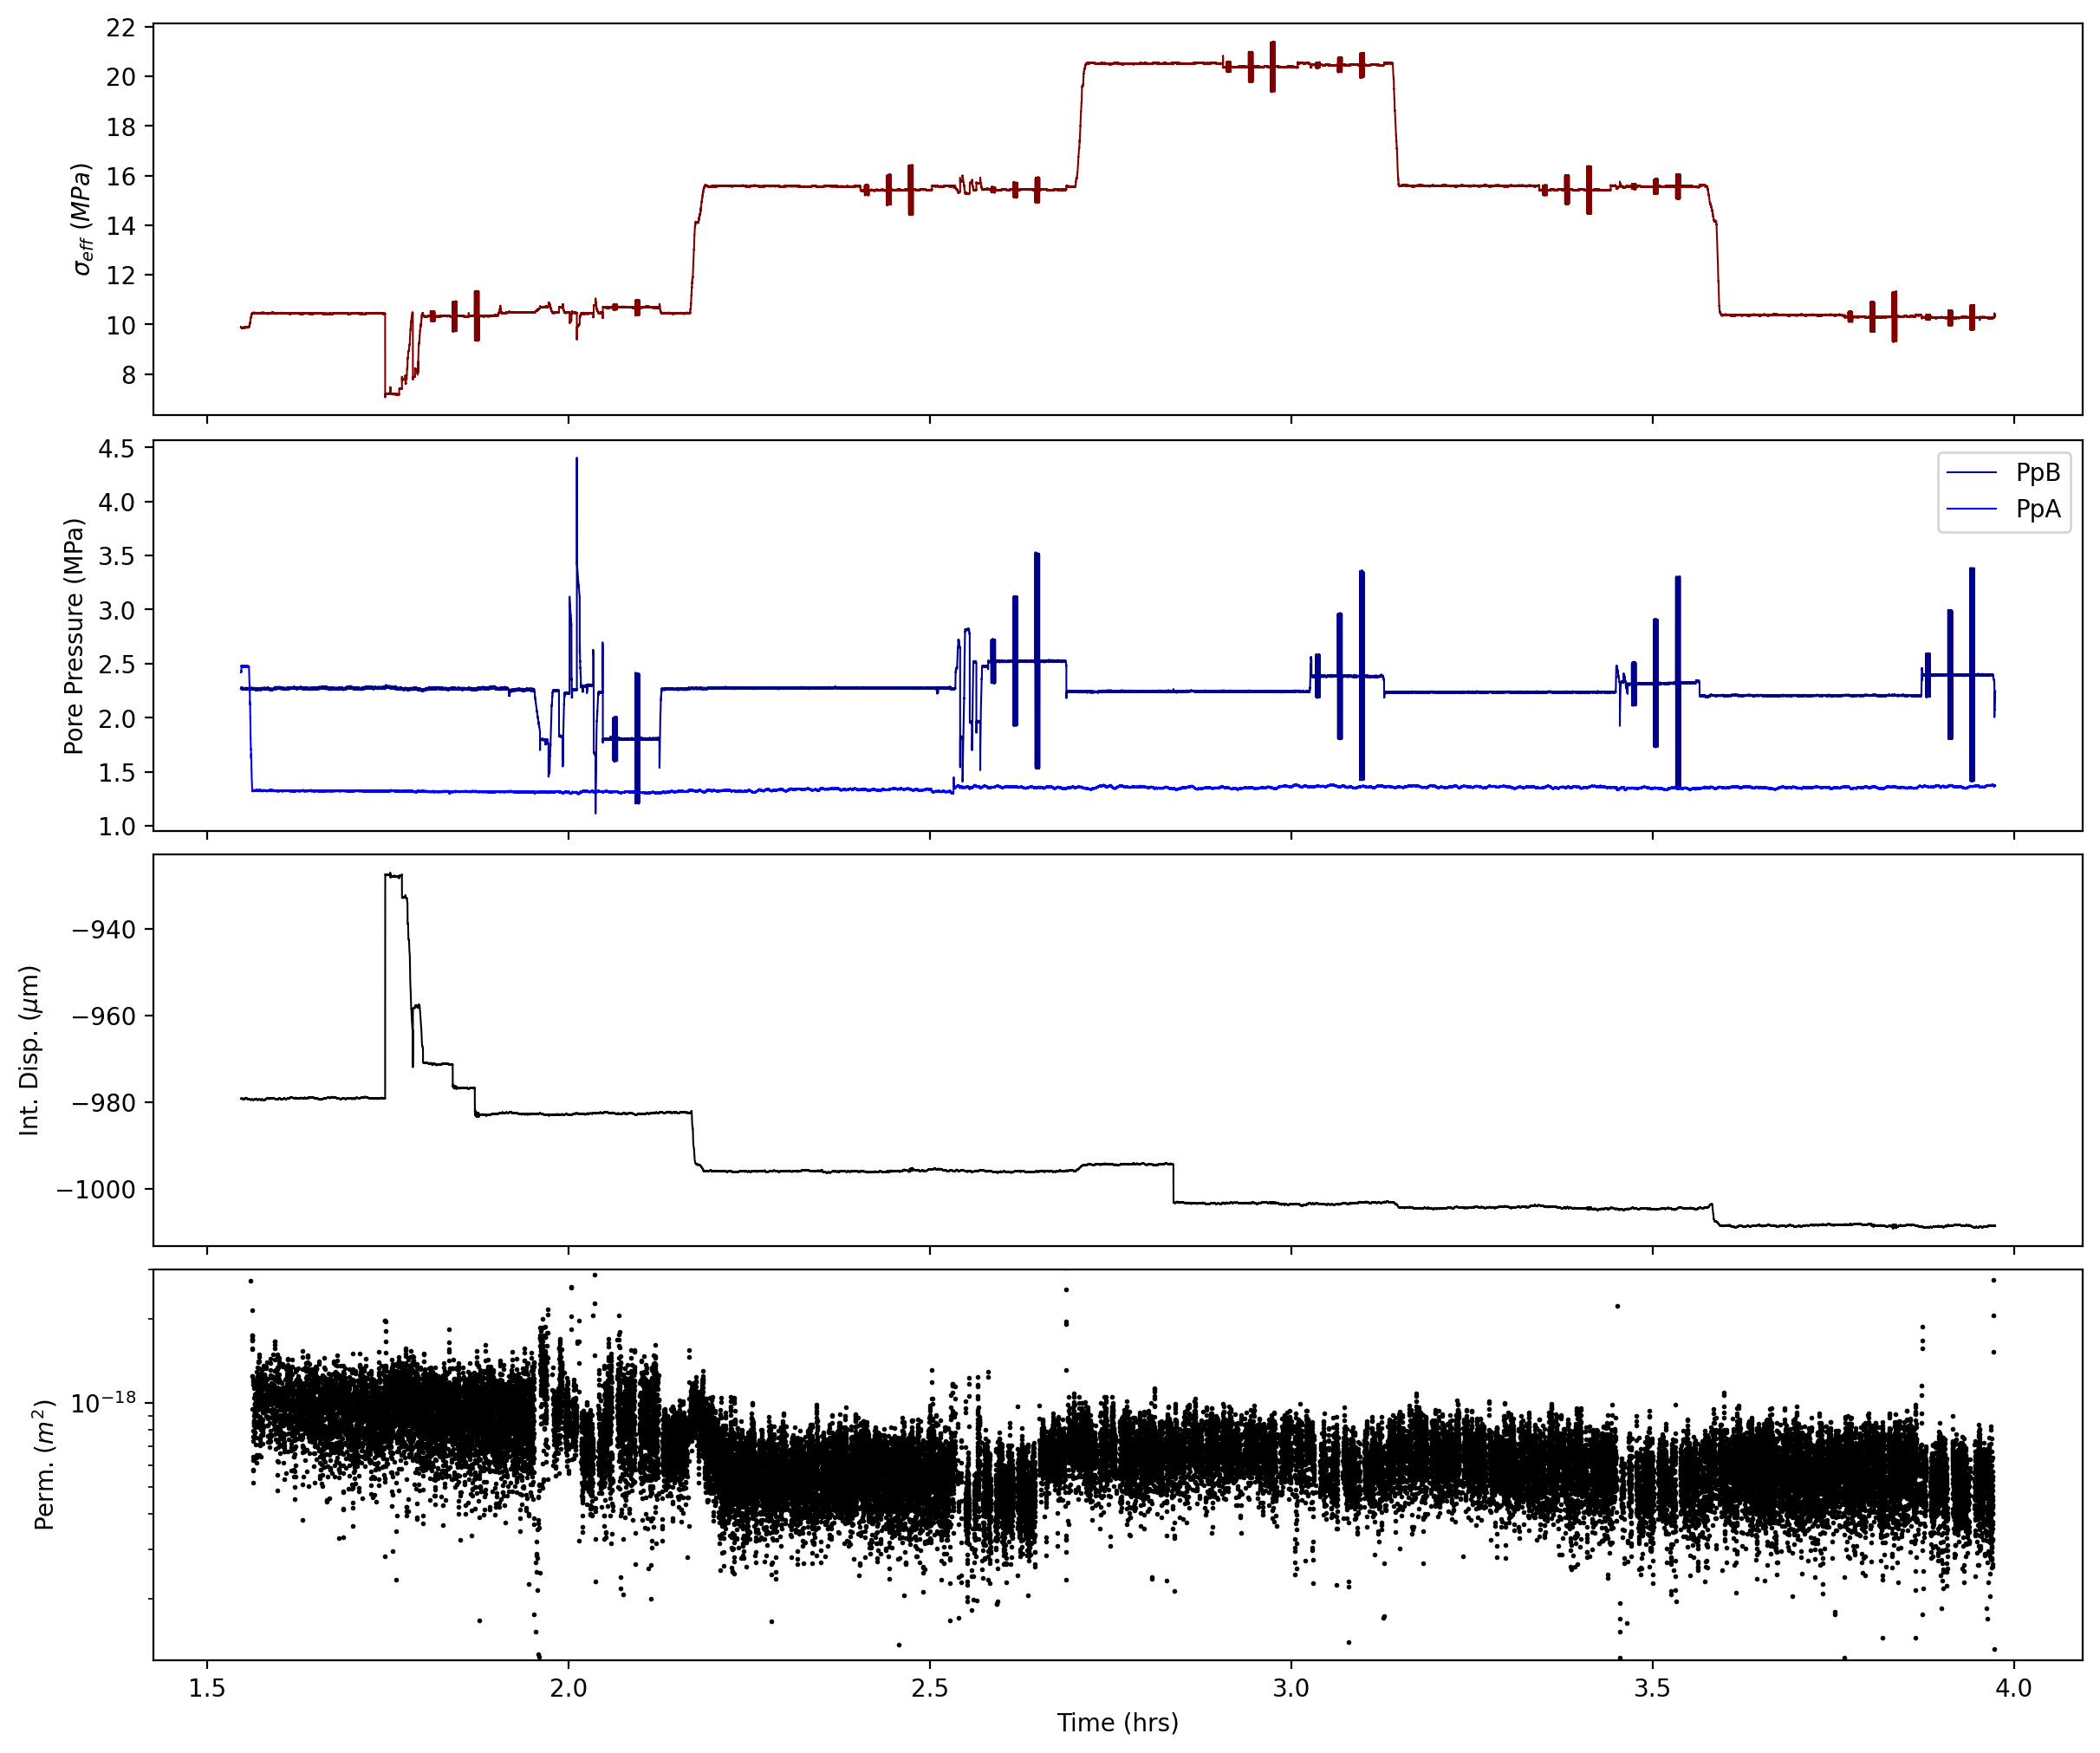

In [15]:
%matplotlib inline
idx1=86000; idx2=960000; dt=10
fig, axs = plt.subplots(4, 1, figsize=(12, 10), sharex=True, dpi=200, constrained_layout=True)
axs[0].plot(data['time'][idx1:idx2:dt]/3600, data['effNS'][idx1:idx2:dt], color='maroon', lw=0.75, zorder=0)
axs[1].plot(data['time'][idx1:idx2:dt]/3600, data['ppb press'][idx1:idx2:dt], color='darkblue', lw=0.75, label='PpB')
axs[1].plot(data['time'][idx1:idx2:dt]/3600, data['ppa press'][idx1:idx2:dt], color='blue',lw=0.75, label='PpA')
axs[1].legend()
axs[2].plot(data['time'][idx1:idx2:dt]/3600, data['int disp'][idx1:idx2:dt], color='black',lw=0.75)
# axs[2].set_ylim((1665,1710))
# axs[3].plot(data['time'][idx1:idx2:dt]/3600, data['perm'][idx1:idx2:dt], color='black',lw=0.75)
axs[3].scatter(data['time'][idx1:idx2:dt]/3600, data['perm'][idx1:idx2:dt], s=1, color='black')
axs[3].set_ylim((1.2e-19, 3e-18))
axs[3].set_yscale('log')
axs[3].set_xlabel('Time (hrs)')
axs[0].set_ylabel('$\sigma_{eff}\ (MPa)$')
axs[1].set_ylabel('Pore Pressure (MPa)')
axs[2].set_ylabel('Int. Disp. ($\mu$m)')
axs[3].set_ylabel('Perm. ($m^2$)')
plt.show()
# # fig.savefig('p5607_part2.png')

In [16]:
# fig, axs = plt.subplots(1, 1, figsize=(12, 5))
# axs.plot(data['perm'], color='r')
# for aa in idxs.flatten():
#     plt.axvline(x=aa, color='black', linestyle='-')
# # axs.plot(data['Qb'], color='b')
# # axs.set_xscale('log')
# # axs.set_yscale('log')
# plt.show()

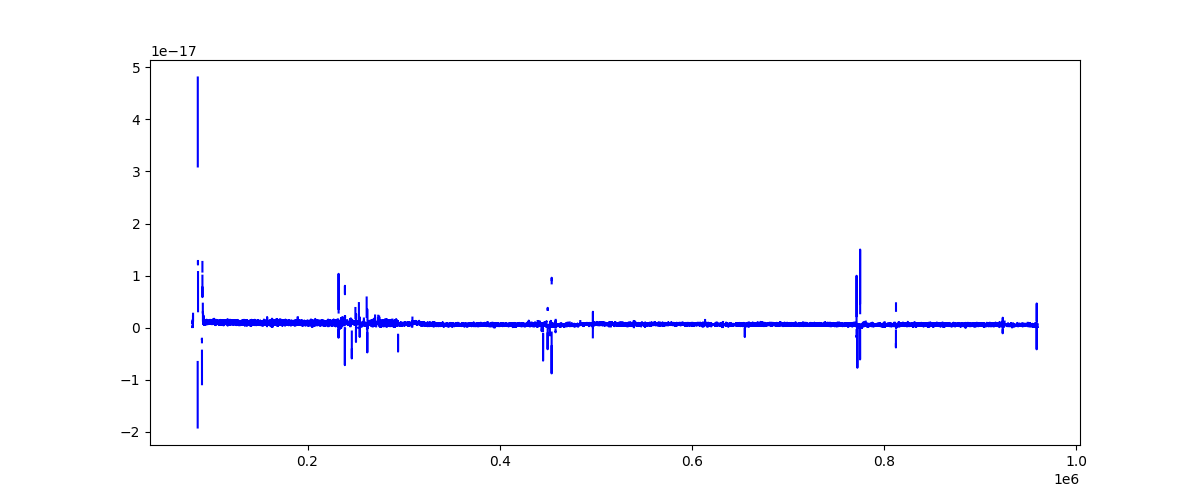

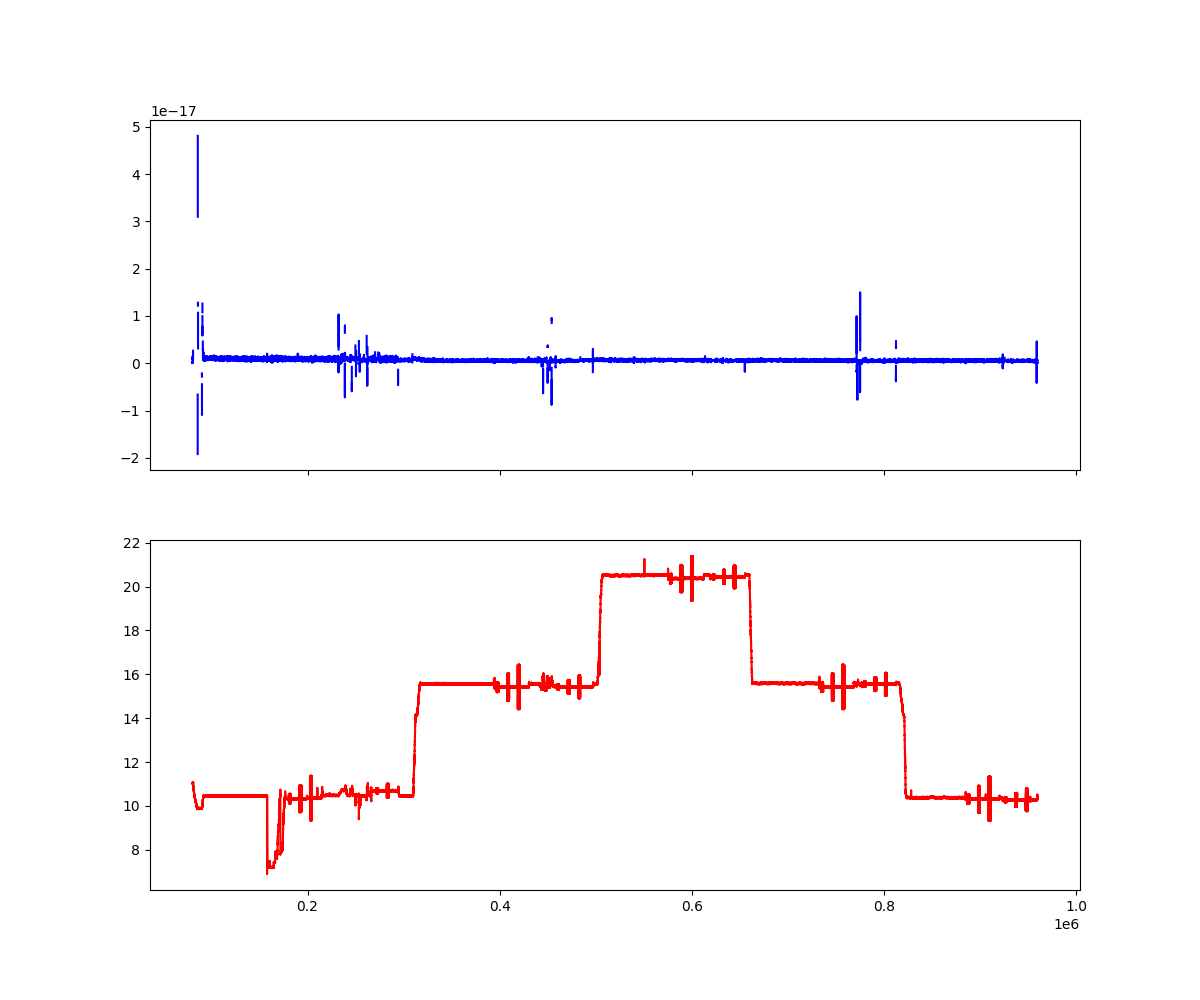

In [17]:
pl('perm', 'effNS', ylog=False, idx1=80000, idx2=960000)

In [18]:
idxs = np.array([92400, 157600, 318600, 393580, 508100, 574670, 663630, 732180, 824090, 884440])
NS_start = np.array([180522, 396785, 577092, 734659, 886812])
PP_start = np.array([271491, 459810, 621508, 778952, 925552])

In [19]:
numOsc = 3
oscLen = 20
holdTime = 90
recFreq = 100

NS_begin = np.zeros((len(NS_start),numOsc), dtype='int')
NS_begin[:,0] = NS_start
PP_begin = np.zeros((len(PP_start),numOsc), dtype='int')
PP_begin[:,0] = PP_start

for bb in range(len(NS_begin)):
    for aa in range(1,numOsc):
        NS_begin[bb,aa] = NS_begin[bb,aa-1] + (oscLen*recFreq) + (holdTime*recFreq)
        PP_begin[bb,aa] = PP_begin[bb,aa-1] + (oscLen*recFreq) + (holdTime*recFreq)
NS_end = (NS_begin+(1.001*oscLen*recFreq)).astype('int')
PP_end = (PP_begin+(1.001*oscLen*recFreq)).astype('int')

In [20]:
permBeforeNS = np.full(len(NS_begin.flatten())+3,np.nan)
permAfterNS = np.full(len(NS_begin.flatten())+3, np.nan)

permBeforePP = np.full(len(PP_begin.flatten())+3,np.nan)
permAfterPP = np.full(len(PP_begin.flatten())+3,np.nan)


for aa in range(len(NS_begin.flatten())):
    permBeforeNS[aa] = np.nanmean(data['perm'][NS_begin.flatten()[aa]-(recFreq*10):NS_begin.flatten()[aa]])
    permAfterNS[aa] = np.nanmean(data['perm'][NS_end.flatten()[aa]:NS_end.flatten()[aa]+(recFreq*10)])
    permBeforePP[aa] = np.nanmean(data['perm'][PP_begin.flatten()[aa]-(recFreq*10):PP_begin.flatten()[aa]])
    permAfterPP[aa] = np.nanmean(data['perm'][PP_end.flatten()[aa]:PP_end.flatten()[aa]+(recFreq*10)])

delPermNS = np.reshape((permAfterNS-permBeforeNS)/permBeforeNS * 100, (6,3))
delPermPP = np.reshape((permAfterPP-permBeforePP)/permBeforePP * 100, (6,3))
delPermPP[0,2] = np.nan

In [21]:
def getAvg(data, key, idxs):
    idxs = np.reshape(idxs,(-1,2))
    avg = np.array(list(map(lambda x: np.nanmean(data[key][idxs[x,0]:idxs[x,1]]), np.arange(len(idxs)))))
    err = np.array(list(map(lambda x: np.nanstd(data[key][idxs[x,0]:idxs[x,1]]), np.arange(len(idxs)))))
    return avg, err

avgPerm, errPerm = getAvg(data, 'perm', idxs)
avgeffNS, erreffNS = getAvg(data, 'effNS', idxs)
avgComp, errComp = getAvg(data, 'int disp', idxs)

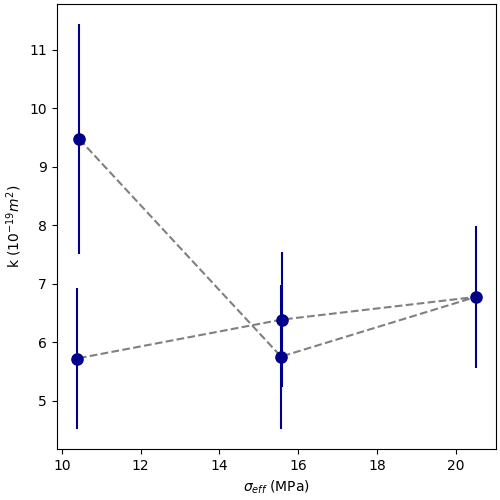

In [22]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5), sharex=True, dpi=100, constrained_layout=True)
axs.plot(avgeffNS, avgPerm*1e19, c='gray', ls='--', zorder=0)
axs.scatter(avgeffNS, avgPerm*1e19, color='darkblue', s=65, zorder=1)
axs.errorbar(avgeffNS, avgPerm*1e19, yerr=errPerm*1e19, fmt='none', color='darkblue', zorder=2)
axs.set_xlabel('$\sigma_{eff}$ (MPa)')
axs.set_ylabel('k ($10^{-19} m^2$)')
plt.show()

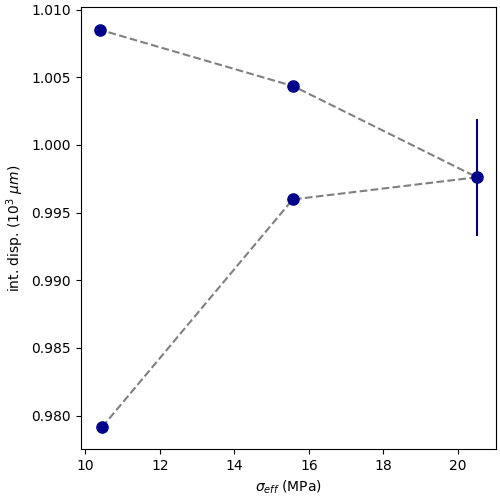

In [23]:
# %matplotlib inline
fig, axs = plt.subplots(1, 1, figsize=(5, 5), sharex=True, dpi=100, constrained_layout=True)
axs.plot(avgeffNS, abs(avgComp)*1e-3, c='gray', ls='--', zorder=0)
axs.scatter(avgeffNS, abs(avgComp)*1e-3, color='darkblue', s=65, zorder=1)
axs.errorbar(avgeffNS, abs(avgComp)*1e-3, yerr=errComp*1e-3, fmt='none', color='darkblue', zorder=2)
axs.set_xlabel('$\sigma_{eff}$ (MPa)')
axs.set_ylabel('int. disp. ($10^{3}\ \mu m$)')
plt.show()

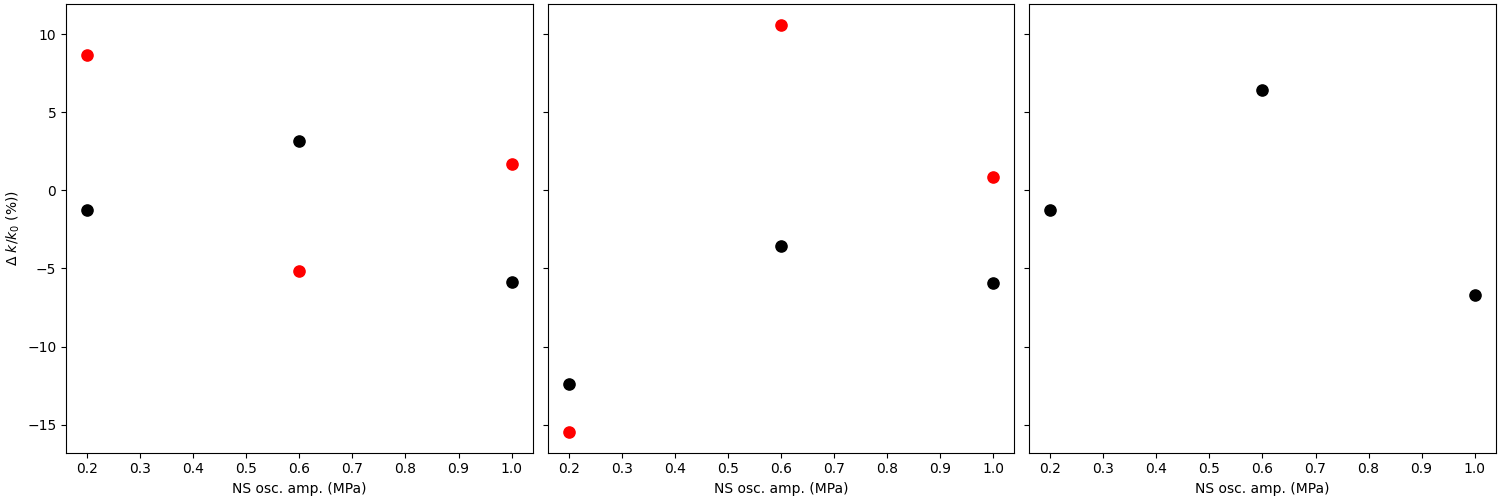

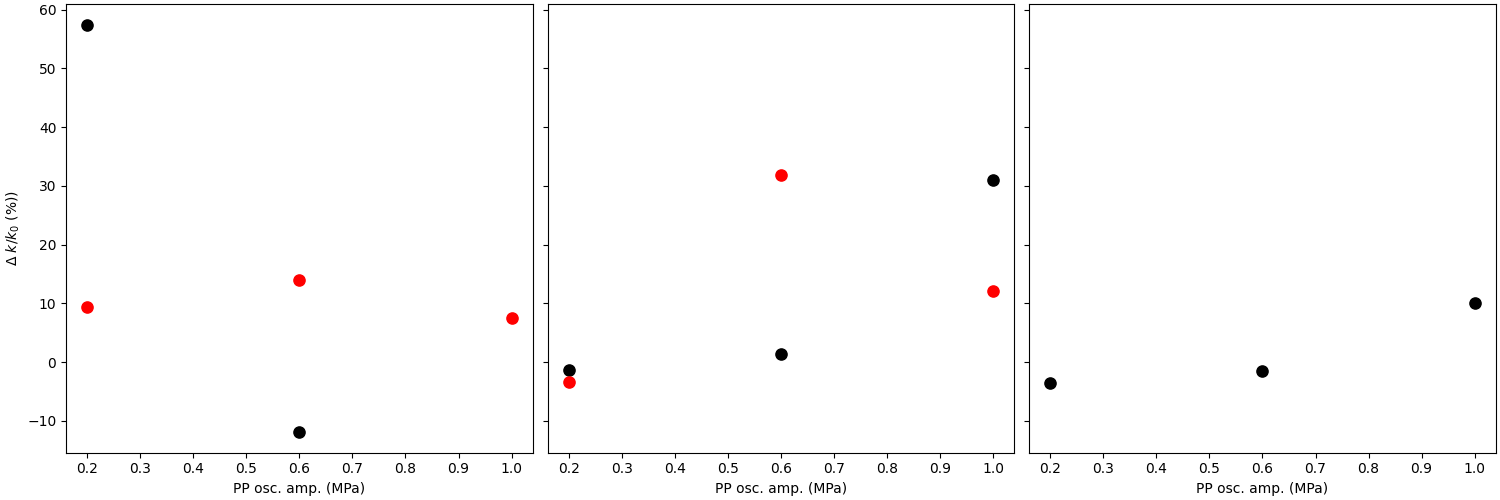

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True, dpi=100, constrained_layout=True)
for aa in range(3):
    axs[aa].scatter(np.array([0.2, 0.6, 1]), delPermNS[aa,:], facecolor='k', s=65)
    axs[aa].scatter(np.array([0.2, 0.6, 1]), delPermNS[aa+3,:], facecolor='r', s=65)
    axs[aa].set_xlabel('NS osc. amp. (MPa)')
axs[0].set_ylabel('$\Delta\ k/k_0$ (%))')
plt.show()

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True, dpi=100, constrained_layout=True)
for aa in range(3):
    axs[aa].scatter(np.array([0.2, 0.6, 1]), delPermPP[aa,:], facecolor='k', s=65)
    axs[aa].scatter(np.array([0.2, 0.6, 1]), delPermPP[aa+3,:], facecolor='r', s=65)
    axs[aa].set_xlabel('PP osc. amp. (MPa)')
axs[0].set_ylabel('$\Delta\ k/k_0$ (%))')
plt.show()

In [25]:
data.drop(['Vert DCDT', 'Vert LOAD', 'PpDiff','mmPpDiff','AvPparate','AvPpbrate','QpctDiff','Qavg'], axis=1, inplace=True)

In [26]:
with h5.File("p5708_r.hdf5", "w") as f:
    for chanName in data.keys():
        f.create_dataset(chanName, data=data[chanName])